# Predict Customer Loan Default Risk

<b>Andreea Nistor</b>

<b>&#x1F4C5; January 12th 2024</b>

## 	&#x26F3; 1. Bussines Understanding

### Project Overview
This project aims to develop a risk model to predict the likelihood of a customer defaulting on their credit card payments. We will use a classifier to determine which customers are likely to be unable to repay their balance within the next 12 months. The model will consider features such as loan amount, demographic data, repayment history, and balance information at various time points. The dataset used is the Default of Credit Card Clients Dataset (Taiwan, 2005), available on Kaggle at this [link](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data).

### Output
- A `.ipynb file`.
- Model file (e.g., in pickle format) and an inference script.
- Relevant visualizations of the analysis within the notebook

### Questions & Answers 
1. How should customers with high vs. low default probability be treated? Is a simple score enough, or are calibrated probabilities needed?<br>
A: High-probability customers should be flagged for immediate action (e.g., offering repayment plans), while low-probability customers can be monitored. Although a simple score can be used, calibrated probabilities are preferred as they better reflect actual risk, enabling more informed decisions and targeted interventions.

2. What infrastructure is needed for deploying this model? Should a smaller CPU machine or a larger GPU-based one be used?<br>
A: A smaller CPU machine will suffice initially, but if more complex models are considered in the future, a machine with GPU support may be necessary. The primary focus should be on ensuring the accuracy of the predictions at this stage.

3. What are the costs associated with misclassifying a customer as likely to default vs. not likely to default?<br>
A: While default costs are not considered at this stage, if they were available, the goal would be to minimize misclassifications by applying a higher penalty for missed defaults to mitigate financial losses.

4. Which business metric or KPI will this prediction most impact?<br>
A: This model will most directly impact the default rate or delinquency rate, as accurate predictions can lead to proactive interventions, reducing defaults and improving profitability while minimizing financial risk.




## 	&#x26F3; Exploratory Data Analysis


Install the necessary libraries

In [1]:
# !pip install --quiet pandas scikit-optimize xgboost shap pywaffle graphviz seaborn

In [2]:
import os  # To handle paths in a way that is portable
import random  # For random number generation
import pandas as pd  # For data understanding and preparation
import numpy as np  # For processing vectors
import seaborn as sns  # For visualization
import matplotlib.pyplot as plt  # For plotting
from matplotlib.colors import LinearSegmentedColormap  # To create custom colormaps
from matplotlib.figure import Figure  # For figure customization
from matplotlib.axes import Axes  # For axes customization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # For data normalization


# Machine learning and model evaluation
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc  # For evaluation metrics
import xgboost as xgb  # For training the XGBoost classifier
import pickle  # To save machine learning models

# Hyperparameter optimization
from skopt import BayesSearchCV  # For hyperparameter optimization
from skopt.space import Integer, Real  # For specifying search space in hyperparameter optimization

# Explainability and visualization
import shap  # For model explainability
from pywaffle import Waffle  # For waffle plots
from graphviz import Digraph  # For visualization of model structure
from IPython.display import Image  # To display model estimators
from typing import Tuple, Union  # For typing function outputs
from pandas import DataFrame  # For typing DataFrame objects



/Users/andreeanistor/Documents/data_sci_projects/credit_risk/credit_risk_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Notebook overview

In [3]:
# Company's brand colours
dark_blue = "#05becd"
light_blue = "#1fe0df"
black = "black"
dark_gray = "#1d1d1f"
gray = "gray"
light_gray = "#d3d3d3"
white = "white"

# balckberry brand colours
blue = '#005387'
green = '#8cb811'
yellow = '#fdb813'
faded_blue = '#88aca1'
purple = '#788cb6'

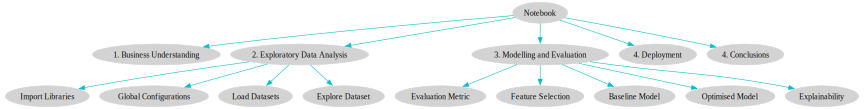

In [4]:
# Initialize a new directed graph
dot = Digraph(comment='Structure of the document')

# Set graph attributes
dot.attr(bgcolor=white)     # Set background color to black
dot.attr(size='12, 10')      # Set size of the graph
dot.attr(rankdir='TB')      # Top to bottom layout (default is TB)

# Set default node and edge attributes
dot.attr('node', style='filled', fillcolor=light_gray, fontcolor=black, color=light_gray)  # Dark blue text, light blue outline
dot.attr('edge', color=dark_blue)  # Light blue arrows

# Define the tree structure
dot.node('A', 'Notebook')                           # Root node
dot.node('B', '1. Business Understanding')          # First child of root
dot.node('C', '2. Exploratory Data Analysis')       # Second child of root
dot.node('D', '3. Modelling and Evaluation')        # Third child of root
dot.node('E', '4. Deployment')                      # Fourth child of root
dot.node('F', '4. Conclusions')                     # Fifth child of root

dot.node('C2', 'Import Libraries')                  # Child of Son 1
dot.node('C3', 'Global Configurations')             # Child of Son 1
dot.node('C4', 'Load Datasets')                     # Child of Son 1
dot.node('C5', 'Explore Dataset')                   # Child of Son 1

dot.node('D1', 'Evaluation Metric')                 # Child of Son 2
dot.node('D2', 'Feature Selection')                 # Child of Son 2
dot.node('D3', 'Baseline Model')                    # Child of Son 2
dot.node('D4', 'Optimised Model')                   # Child of Son 2
dot.node('D5', 'Explainability')                    # Child of Son 2


# Define edges between nodes to create hierarchy
dot.edge('A', 'B')              # Father -> Son
dot.edge('A', 'C')              # Father -> Son
dot.edge('A', 'D')              # Father -> Son
dot.edge('A', 'E')              # Father -> Son
dot.edge('A', 'F')              # Father -> Son

dot.edge('C', 'C2')              # Son -> Grandson
dot.edge('C', 'C3')              # Son -> Grandson
dot.edge('C', 'C4')              # Son -> Grandson
dot.edge('C', 'C5')              # Son -> Grandson

dot.edge('D', 'D1')              # Son -> Grandson
dot.edge('D', 'D2')              # Son -> Grandson
dot.edge('D', 'D3')              # Son -> Grandson
dot.edge('D', 'D4')              # Son -> Grandson
dot.edge('D', 'D5')              # Son -> Grandson


# Render and display the tree
display(dot)

Helper functions

In [5]:
def plot_roc_curve(
    y_true: Union[list, np.ndarray], 
    y_pred_prob: Union[list, np.ndarray], 
    dataset: str
) -> None:
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a given dataset.

    Args:
        y_true (Union[list, np.ndarray]): True binary labels.
        y_pred_prob (Union[list, np.ndarray]): Predicted probabilities for the positive class.
        dataset (str): Name of the dataset to include in the plot title.

    Returns:
        None
    """
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) ' + dataset.capitalize())
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


def missing_values_summary(df: DataFrame) -> DataFrame:
    """
    Summarizes columns in a DataFrame with significant missing values.

    Args:
        df (DataFrame): The input DataFrame to analyze.

    Returns:
        DataFrame: A DataFrame containing the count and percentage of missing values 
                   for columns with more than 70% missing data, sorted by percentage 
                   in descending order.

    The returned DataFrame has the following structure:
        - `Missing Values`: Total number of missing values per column.
        - `Percentage`: Percentage of missing values per column.
    """
    # Count total missing values for each column
    missing_count = df.isnull().sum()

    # Calculate percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Create a DataFrame summarizing the missing data
    missing_summary = pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage': missing_percentage
    })

    # Filter only columns with missing data and sort by the most missing
    missing_summary = missing_summary[missing_summary['Percentage'] > 70]
    missing_summary = missing_summary.sort_values(by='Percentage', ascending=False)

    return missing_summary


def plot_correlation_matrix(df: pd.DataFrame, threshold: float=0.8, figsize: Tuple[int, int]=(14, 14)) -> Tuple[Figure, Axes]:
    """
    Plots a heatmap of the correlation matrix for the given DataFrame.

    This function visualizes feature correlations in a clear and concise way:
    - The lower triangle displays all correlations.
    - The upper triangle only displays correlations with an absolute value greater than 0.6.
    - Correlation values are annotated on the heatmap for better interpretability.
    - A custom dark-red-to-white colormap is used to emphasize the strength of correlations.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing numerical features to compute the correlation matrix.

    Returns:
        Tuple[Figure, Axes]: A tuple containing the Matplotlib `figure` and `axes` objects.
    """
    # Calculate the correlation matrix
    corr = df.corr()
    
    # Convert correlation matrix to numpy array for easier indexing
    corr_array = corr.values
    feature_names = corr.columns
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_array, dtype=bool))
    
    # Mask correlations below the threshold
    mask_lower = np.abs(corr_array) < threshold
    mask = mask & mask_lower
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create custom colormap: dark red -> white -> dark red
    colors = [(0.55, 0, 0), (1, 1, 1), (0.55, 0, 0)]  # dark red, white, dark red
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
    
    # Plot the masked heatmap
    masked_corr = np.ma.masked_where(mask, corr_array)
    cax = ax.imshow(masked_corr, cmap=custom_cmap, interpolation='nearest', vmin=-1, vmax=1)
    
    # Add correlation values
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            if not mask[i, j]:  # Only show values where mask is False
                text_color = 'white' if abs(corr_array[i, j]) > 0.5 else 'black'
                ax.text(j, i, f'{corr_array[i, j]:.2f}', 
                       ha='center', va='center', color=text_color)
    
    # Add color bar
    cbar = fig.colorbar(cax, ax=ax, shrink=0.8)
    cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")
    
    # Set axis labels
    ax.set_xticks(np.arange(len(feature_names)))
    ax.set_yticks(np.arange(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation=90)
    ax.set_yticklabels(feature_names)
    
    # Add labels for x and y axes
    plt.xlabel('Features', size=12)
    plt.ylabel('Features', size=12)
    plt.title(f'Correlation Matrix : All Correlations Below the Diagonal;\nAbove the Diagonal, Only Correlations > ±{threshold}', size=16)
    
    # Remove gridlines
    ax.grid(False)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax



### Load Dataset

<b>Dataset Information</b><br>
This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

<b>Content</b><br>
There are 25 variables:

ID: ID of each client<br>
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit<br>
SEX: Gender (1=male, 2=female)<br>
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)<br>
MARRIAGE: Marital status (1=married, 2=single, 3=others)<br>
AGE: Age in years<br>
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)<br>
PAY_2: Repayment status in August, 2005 (scale same as above)<br>
PAY_3: Repayment status in July, 2005 (scale same as above)<br>
PAY_4: Repayment status in June, 2005 (scale same as above)<br>
PAY_5: Repayment status in May, 2005 (scale same as above)<br>
PAY_6: Repayment status in April, 2005 (scale same as above)<br>
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)<br>
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)<br>
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)<br>
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)<br>
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)<br>
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)<br>
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)<br>
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)<br>
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)<br>
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)<br>
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)<br>
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)<br>
default.payment.next.month: Default payment (1=yes, 0=no)<br>

Download <i>Default of Credit Card Clients Dataset</i> from Kaggle

In [6]:
# # uncoment the following lines to download the dataset

# # Download the dataset
# !kaggle datasets download -d uciml/default-of-credit-card-clients-dataset
# # Create the ./data directory if it doesn't exist
# !mkdir -p ./data

# # Unzip the dataset into the ./data folder
# !unzip default-of-credit-card-clients-dataset.zip -d ./data

# # Delete the zip file
# !rm default-of-credit-card-clients-dataset.zip

In [7]:
path = 'data/UCI_Credit_Card.csv'
data = pd.read_csv(path)

### Explore Dataset

In [8]:
data.info()

# no missing values
# all columns are numerical
# target variable is 'default.payment.next.month'
# 30,000 rows and 25 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

&#x2757; In this dataset, there are no missing values. However, if missing data were present, it would be important to either remove or impute the missing values, depending on the dataset characteristics. 

&#x2757; The dataset consists of both numeric and categorical columns, but as the categorical columns (SEX, EDUCATION, MARRIAGE) are already encoded as integers, no further encoding is required for these features. However, if there were non-numeric factors in the future, techniques like one-hot encoding or LabelEncoder can be used.

In [9]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [10]:
for col in data[['SEX', 'EDUCATION', 'MARRIAGE']].columns:
    print(data[col].value_counts().sort_index()) 


# EDUCATION column has 0, values which is not documented in the dataset description ; 5 and 6 are both marked as 'unknown' and 4 is 'others' => replace 0, 5, 6 with 4 meaning 'others'
# MARRIAGE column has 0, values which is not documented in the dataset description => replace 0 with 3 meaning 'others'


SEX
1    11888
2    18112
Name: count, dtype: int64
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64


In [11]:
# Replace values in the EDUCATION column
data['EDUCATION'] = data['EDUCATION'].replace({0: 4, 5: 4, 6: 4})

# Replace values in the MARRIAGE column
data['MARRIAGE'] = data['MARRIAGE'].replace({0: 3})

for col in data[['SEX', 'EDUCATION', 'MARRIAGE']].columns:
    print(data[col].value_counts().sort_index()) 

SEX
1    11888
2    18112
Name: count, dtype: int64
EDUCATION
1    10585
2    14030
3     4917
4      468
Name: count, dtype: int64
MARRIAGE
1    13659
2    15964
3      377
Name: count, dtype: int64


In [12]:
pay_columns = data[[col for col in data.columns if col.startswith('PAY_') and col[4:].isdigit()]].columns

for col in pay_columns:
    print(data[col].value_counts().sort_index()) 

# there are -2 values in the data set and this value is not documented in the dataset description
# it seems that PAY_[digit] columns have the original values shifted by -1 
# (the description says values range from -1 means 'pay duly' to 9 means 'payment delay for 9 months and above')
# we will consider -2 means -1 and shift all values by 1. 


PAY_0
-2     2759
-1     5686
 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64
PAY_2
-2     3782
-1     6050
 0    15730
 1       28
 2     3927
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
Name: count, dtype: int64
PAY_3
-2     4085
-1     5938
 0    15764
 1        4
 2     3819
 3      240
 4       76
 5       21
 6       23
 7       27
 8        3
Name: count, dtype: int64
PAY_4
-2     4348
-1     5687
 0    16455
 1        2
 2     3159
 3      180
 4       69
 5       35
 6        5
 7       58
 8        2
Name: count, dtype: int64
PAY_5
-2     4546
-1     5539
 0    16947
 2     2626
 3      178
 4       84
 5       17
 6        4
 7       58
 8        1
Name: count, dtype: int64
PAY_6
-2     4895
-1     5740
 0    16286
 2     2766
 3      184
 4       49
 5       13
 6       19
 7       46
 8        2
Name: count, dtype: int64


In [13]:
data[pay_columns] = data[pay_columns] + 1

for col in pay_columns:
    print(data[col].value_counts().sort_index()) # all values are now in the range [-1, 9] as per data description

PAY_0
-1     2759
 0     5686
 1    14737
 2     3688
 3     2667
 4      322
 5       76
 6       26
 7       11
 8        9
 9       19
Name: count, dtype: int64
PAY_2
-1     3782
 0     6050
 1    15730
 2       28
 3     3927
 4      326
 5       99
 6       25
 7       12
 8       20
 9        1
Name: count, dtype: int64
PAY_3
-1     4085
 0     5938
 1    15764
 2        4
 3     3819
 4      240
 5       76
 6       21
 7       23
 8       27
 9        3
Name: count, dtype: int64
PAY_4
-1     4348
 0     5687
 1    16455
 2        2
 3     3159
 4      180
 5       69
 6       35
 7        5
 8       58
 9        2
Name: count, dtype: int64
PAY_5
-1     4546
 0     5539
 1    16947
 3     2626
 4      178
 5       84
 6       17
 7        4
 8       58
 9        1
Name: count, dtype: int64
PAY_6
-1     4895
 0     5740
 1    16286
 3     2766
 4      184
 5       49
 6       13
 7       19
 8       46
 9        2
Name: count, dtype: int64


&#x2757;	 The dataset variables have different scales. If using a model sensitive to feature scaling, standardize the values for consistent performance.

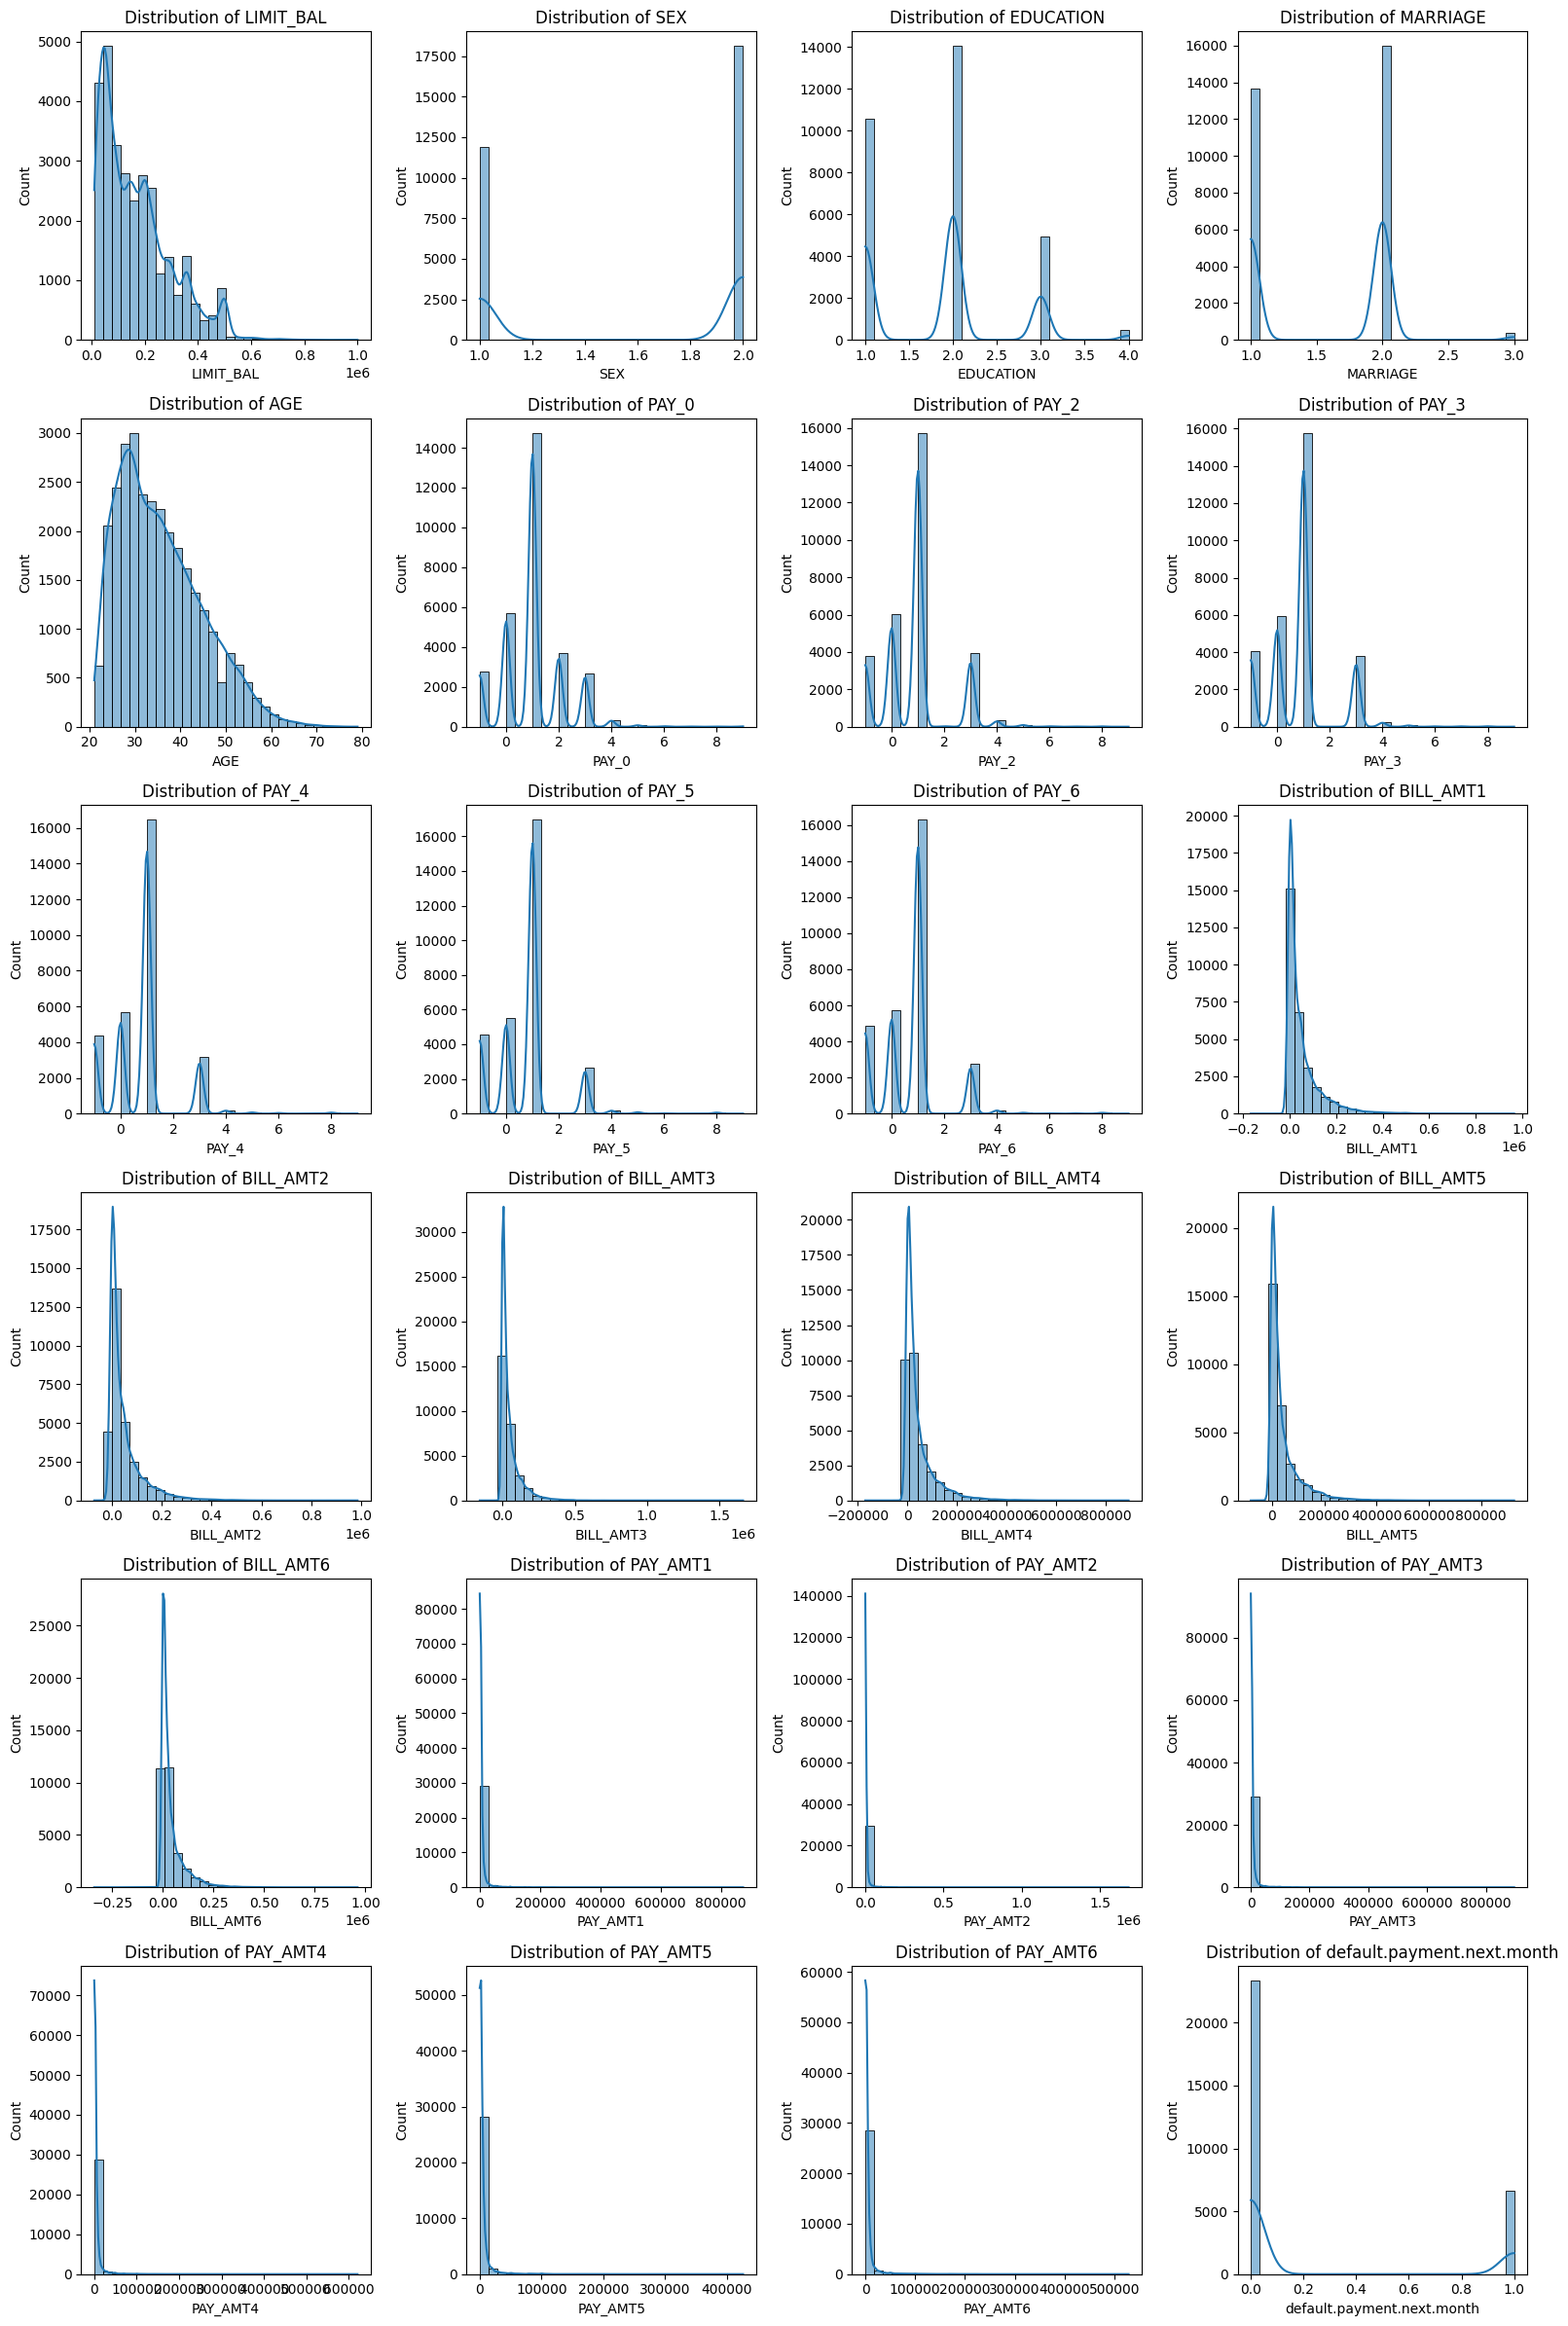

In [14]:
# Exclude the 'ID' column
df_no_id = data.drop(columns=['ID'])

# Create a grid plot for all columns in the dataset (excluding 'ID')
num_columns = len(df_no_id.columns)
n_rows = (num_columns + 3) // 4  # To arrange in a grid with 4 columns

plt.figure(figsize=(16, 4 * n_rows))

# Loop through each column and plot its distribution
for i, column in enumerate(df_no_id.columns):
    plt.subplot(n_rows, 4, i + 1)
    sns.histplot(df_no_id[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


The target variable in this dataset is imbalanced, and the feature data is positively skewed, with some negative values. These factors must be considered when selecting a model.

Decision tree-based models, like XGBoost and Random Forest, handle imbalanced data well and don’t require a normal distribution. XGBoost tends to be more precise in predictions and is optimized for fast training. However, Random Forest offers better interpretability. If interpretability becomes important, SHAP values can be used with XGBoost to determine feature importance ( [reference link](https://www.geeksforgeeks.org/difference-between-random-forest-vs-xgboost/) ). 

Given that this is a credit default predictive model, where precision and accuracy are more important than interpretability, XGBoost is my model of choice. It can effectively handle skewed features and imbalanced targets. While transformations like log or Box-Cox can improve performance and reduce training time, they’re not strictly necessary. For imbalanced targets, techniques like adjusting class weights, using SMOTE, or tweaking the scale_pos_weight parameter can help focus the model on the minority class, though these adjustments may not always be required.

This approach should help improve results in challenging datasets.

Credit default and demographics

/var/folders/gg/9r5r1_cx0j332ldkpzq14jfw0000gn/T/ipykernel_93287/2823290837.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Male', 'Female'])
/var/folders/gg/9r5r1_cx0j332ldkpzq14jfw0000gn/T/ipykernel_93287/2823290837.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([
/var/folders/gg/9r5r1_cx0j332ldkpzq14jfw0000gn/T/ipykernel_93287/2823290837.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['Married', 'Single', 'Others'])


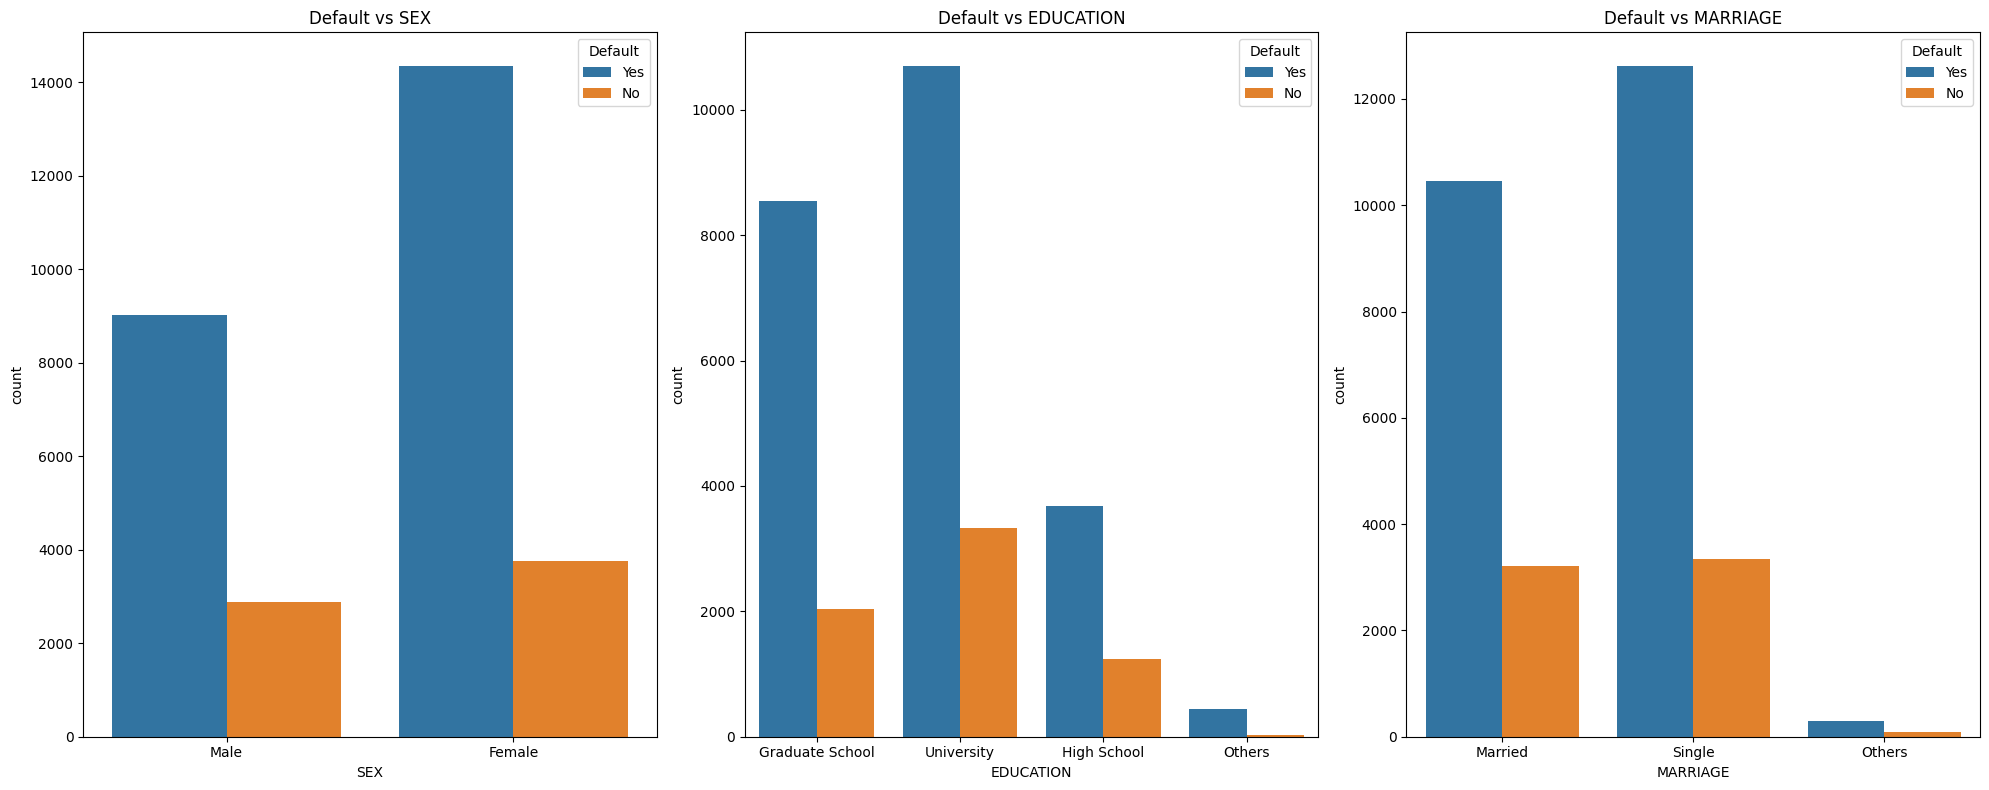

In [15]:
columns_to_plot = ['default.payment.next.month', 'SEX', 'EDUCATION', 'MARRIAGE']

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot default.payment.next.month vs SEX
sns.countplot(data=data, x='SEX', hue='default.payment.next.month', ax=axes[0])
axes[0].set_title('Default vs SEX')

# Modify the SEX labels
axes[0].set_xticklabels(['Male', 'Female'])

# Modify the default.payment.next.month labels in the legend
axes[0].legend(title='Default', labels=['Yes', 'No'])

# Plot default.payment.next.month vs EDUCATION
sns.countplot(data=data, x='EDUCATION', hue='default.payment.next.month', ax=axes[1])
axes[1].set_title('Default vs EDUCATION')

# Modify the EDUCATION labels
axes[1].set_xticklabels([
    'Graduate School', 'University', 'High School', 'Others', 'Unknown', 'Unknown'
])

# Modify the default.payment.next.month labels in the legend
axes[1].legend(title='Default', labels=['Yes', 'No'])

# Plot default.payment.next.month vs MARRIAGE
sns.countplot(data=data, x='MARRIAGE', hue='default.payment.next.month', ax=axes[2])
axes[2].set_title('Default vs MARRIAGE')

# Modify the MARRIAGE labels
axes[2].set_xticklabels(['Married', 'Single', 'Others'])

# Modify the default.payment.next.month labels in the legend
axes[2].legend(title='Default', labels=['Yes', 'No'])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Females tend to default more than males. Higher-educated individuals appear to default more frequently, likely because they are more represented in the dataset—possibly due to their greater access to loans. Single people also seem to default more than married individuals, but the difference is relatively small.

Split dataset into train and test sets

In [16]:
TARGET = 'default.payment.next.month'
cols_to_drop = [TARGET, 'ID']

X = data.drop(columns=cols_to_drop)  # Features (input variables)
y = data[TARGET]  # Target variable (label)

# Split the data into training and test sets, ensuring stratification on the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [17]:
X_train.shape, X_test.shape

((24000, 23), (6000, 23))

In [18]:
y_train.shape, y_test.shape

((24000,), (6000,))

Investigate multi - collinearity and target correlations

In [19]:
traindata = pd.concat([X_train, y_train], axis=1)
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 8291 to 735
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   24000 non-null  float64
 1   SEX                         24000 non-null  int64  
 2   EDUCATION                   24000 non-null  int64  
 3   MARRIAGE                    24000 non-null  int64  
 4   AGE                         24000 non-null  int64  
 5   PAY_0                       24000 non-null  int64  
 6   PAY_2                       24000 non-null  int64  
 7   PAY_3                       24000 non-null  int64  
 8   PAY_4                       24000 non-null  int64  
 9   PAY_5                       24000 non-null  int64  
 10  PAY_6                       24000 non-null  int64  
 11  BILL_AMT1                   24000 non-null  float64
 12  BILL_AMT2                   24000 non-null  float64
 13  BILL_AMT3                   24000 n

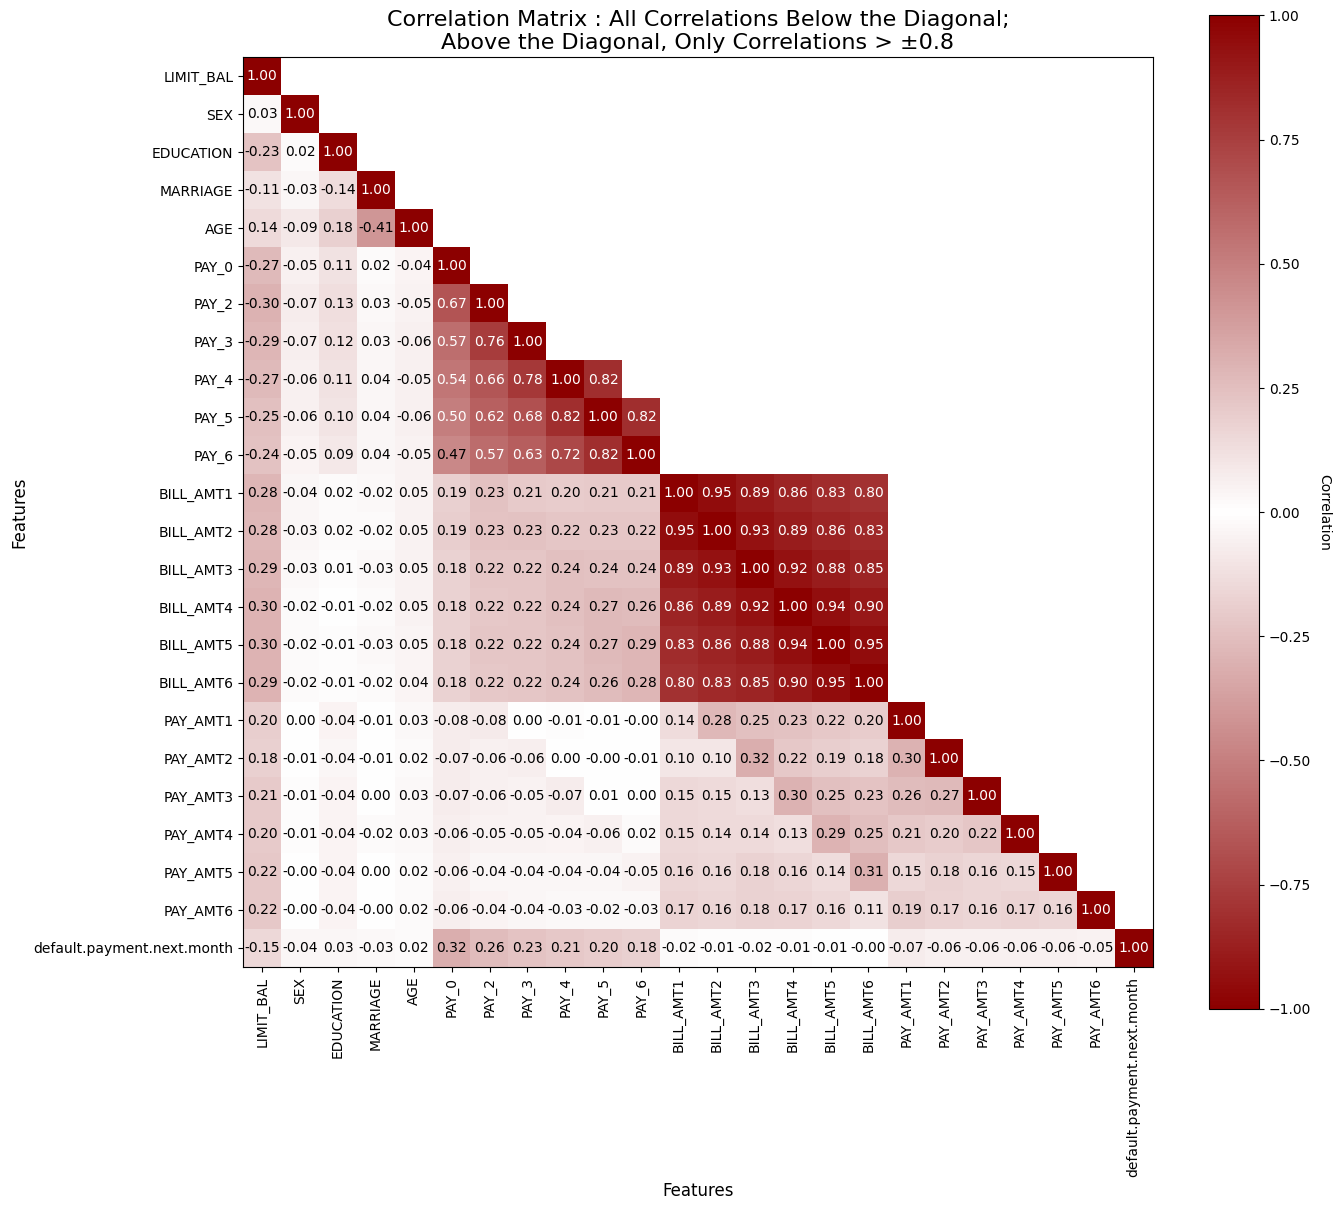

In [20]:
# Calculate and plot the correlation matrix
fig, ax = plot_correlation_matrix(traindata)
plt.show()

&#x2757; Multicollinearity is present in the dataset and should be addressed when using models sensitive to it, like logistic regression. However, this is not a major concern in our case, as we will be using a decision tree-based model, which is better suited to the characteristics of the dataset discussed earlier.

&#x2757; Multicollinearity is not an issue for Random Forest or XGBoost because tree-based models select only one of the correlated features when splitting, so accuracy remains unaffected. However, it can impact feature importance metrics, as importance may be split between correlated features, making interpretation harder.

&#x2757; We observe that the Default target variable shows a small positive correlation with the repayment status factor and a small negative correlation with the initial loan amount (i.e., lower amounts tend to default more frequently). Since we plan to use Random Forest or XGBoost, we can include all factors, as these models inherently perform feature selection. If we were using models like regression, we would remove any factors that do not show meaningful correlations with the target variable.

In [21]:
# Select only the 'BILL_AMT' columns
bill_df = X_train.filter(like='BILL_AMT')  

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(bill_df)

# Perform PCA
pca = PCA(n_components=6)  # The number of principal components
pca.fit_transform(scaled_data)

# Get the loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so each column corresponds to a PC
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=bill_df.columns  # Feature names as index
)

# Scale loadings by the square root of the explained variance
scaled_loadings = loadings * np.sqrt(pca.explained_variance_)

# Print the loadings
print("Feature Loadings (scaled):")
print(scaled_loadings)

# Create a DataFrame with the principal components
principal_components = pca.transform(scaled_data)
pca_df = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Check explained variance ratio
print("\nExplained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", pca.explained_variance_ratio_.sum())

# Print the resulting PCA DataFrame
print("\nPrincipal Components:")
print(pca_df)


Feature Loadings (scaled):
                PC1       PC2       PC3       PC4       PC5       PC6
BILL_AMT1  0.933863  0.299306 -0.147832  0.065316 -0.090886  0.063069
BILL_AMT2  0.956045  0.240203 -0.043447 -0.027906  0.128668 -0.095396
BILL_AMT3  0.960380  0.096221  0.206095 -0.147141 -0.028719  0.059183
BILL_AMT4  0.965474 -0.102992  0.154609  0.154669 -0.051384 -0.082626
BILL_AMT5  0.955919 -0.239246 -0.029476  0.065529  0.099385  0.118247
BILL_AMT6  0.933779 -0.292819 -0.149320 -0.112420 -0.059918 -0.061892

Explained Variance Ratio: [0.90434828 0.05168595 0.01888021 0.01125793 0.00695778 0.00686985]
Total Explained Variance: 1.0

Principal Components:
            PC1       PC2       PC3       PC4       PC5       PC6
0     -0.474311  0.132026 -0.155032  0.031254 -0.011401  0.007994
1     -1.651829 -0.036692  0.019197 -0.001016  0.008013 -0.002358
2      0.786289 -0.281435  0.032356 -0.021362  0.002062 -0.035894
3     -1.330844  0.248295  0.071193 -0.144092  0.040002  0.024736
4    

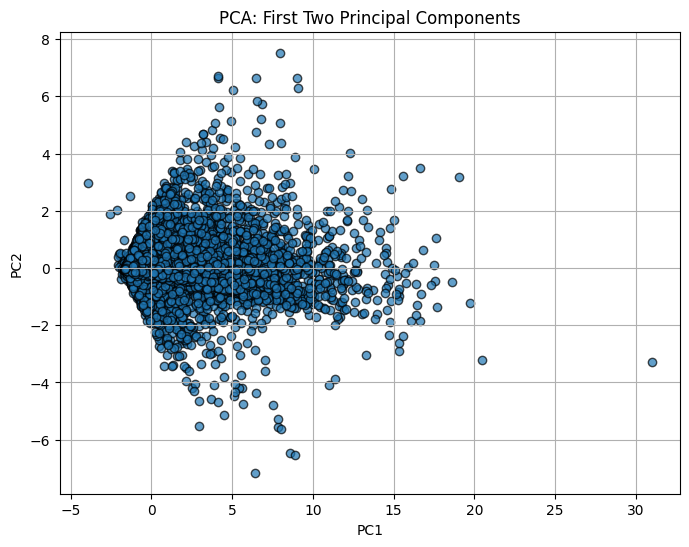

In [22]:
# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolors='k')
plt.title('PCA: First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

As observed above, the variance in the BILL_AMT factor is predominantly explained by the first principal component (PC1), which seems to represent the overall bill amount, regardless of the specific month. We could consider using this single component as a feature in the model, if we prioritize interpretability. However, there are several strategies to handle collinearity in the data:

Aggregation: Combine correlated features using simple aggregation methods such as the mean or sum.<br>
Feature Selection: Retain only one feature from highly correlated pairs by leveraging feature importance metrics to identify the most relevant variables.<br>
Regularization: Use XGBoost's built-in L1 (Lasso) or L2 (Ridge) regularization to penalize less important correlated features, effectively reducing their influence.<br>
Correlation Thresholding: Remove features that exceed a predefined correlation threshold to minimize redundancy in the feature set.<br>

Although tree-based models like XGBoost are generally not sensitive to multicollinearity, we could still choose to mitigate it in order to enhance the interpretability of the model.

In [23]:
# Calculate the correlation matrix
corr = traindata.corr()
# Find columns with a correlation higher than 0.8
high_corr_columns = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            high_corr_columns.add(colname)
            high_corr_columns.add(corr.columns[j])

# Convert to list
high_corr_columns = list(high_corr_columns)

high_corr_columns

['BILL_AMT3',
 'BILL_AMT1',
 'PAY_4',
 'BILL_AMT6',
 'PAY_6',
 'PAY_5',
 'BILL_AMT2',
 'BILL_AMT4',
 'BILL_AMT5']

Download <i>Default of Credit Card Clients Dataset</i> from Kaggle

In [24]:
# Total number of columns in the original dataframe
total_columns = len(traindata.columns)

# Number of columns removed
num_missing = len(missing_values_summary(traindata).index)
num_non_numeric = len(traindata.select_dtypes(exclude=[np.number]).columns)
num_high_corr = len(high_corr_columns)
print( num_missing, num_non_numeric, num_high_corr)

# Number of remaining columns
remaining_columns = total_columns - (num_missing + num_non_numeric + num_high_corr)

# Calculate percentages
percent_missing = (num_missing / total_columns) #* 100
percent_non_numeric = (num_non_numeric / total_columns) #* 100
percent_high_corr = (num_high_corr / total_columns) #* 100
percent_remaining = (remaining_columns / total_columns) #* 100

# Print results
print(f"Total columns: {total_columns}")
print(f"Number of columns with high percentage of missing values: {num_missing} ({percent_missing:.2f}%)")
print(f"Number of non-numeric columns: {num_non_numeric} ({percent_non_numeric:.2f}%)")
print(f"Number of highly correlated columns: {num_high_corr} ({percent_high_corr:.2f}%)")
print(f"Number of remaining columns: {remaining_columns} ({percent_remaining:.2f}%)")

0 0 9
Total columns: 24
Number of columns with high percentage of missing values: 0 (0.00%)
Number of non-numeric columns: 0 (0.00%)
Number of highly correlated columns: 9 (0.38%)
Number of remaining columns: 15 (0.62%)


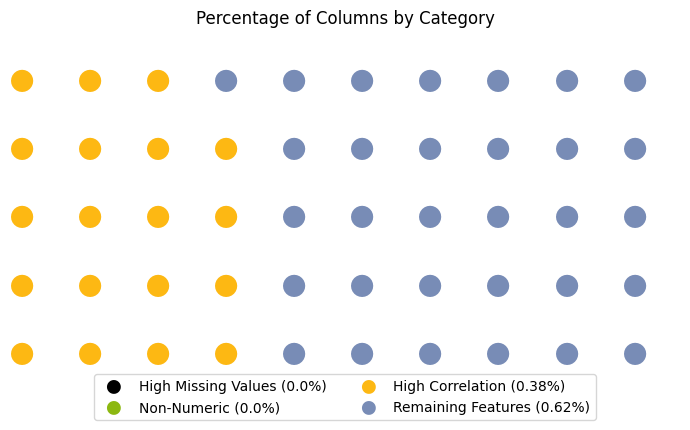

In [25]:
# Data for waffle chart
data = {
    'High Missing Values': percent_missing,
    'Non-Numeric': percent_non_numeric,
    'High Correlation': percent_high_corr,
    'Remaining Features': percent_remaining
}

# Prepare data for waffle chart
percents_of_groups_of_categories = pd.Series(data)

# Colors for each group
colors = [  black,  green, yellow, purple]   
# blue = '#005387'
# green = '#8cb811'
# yellow = '#fdb813'
# faded_blue = '#88aca1'
# purple 

# Create waffle chart
plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=percents_of_groups_of_categories,
    colors=colors,
    title={'label': 'Percentage of Columns by Category'},
    labels=[f"{k} ({round(v,2)}%)" for k, v in percents_of_groups_of_categories.items()],
    legend={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.2), 'ncol': 2, 'fancybox': True},
    icon_legend=True,
    icon_size=16,
    icons='circle'
)



# Adjust the figure size if needed
plt.gcf().set_size_inches(7, 5)  # Increase width and height for more space
plt.show()

## 	&#x26F3; Modelling and Evaluation

### Evaluation Metric

<b>F1 Score:</b><br>
- <b>Balances Precision and Recall</b>: Defined as the harmonic mean of precision and recall, it’s particularly helpful when precision and recall are equally important in the evaluation.
- <b>Focuses on Trade-offs</b>: Useful when you need to strike a balance between minimizing false positives (high precision) and maximizing true positives (high recall).
- <b>Effective for Unbalanced Datasets</b>: Particularly useful when the target variable is imbalanced, as it gives a single metric that considers both false positives and false negatives.
- <b>Best for Similar Costs of Errors</b>: It’s most effective when false positives and false negatives have similar costs or consequences.

<b>AUC (Area Under the ROC Curve)</b>:
- <b>Evaluates Model Performance Across All Thresholds</b>: Measures the area under the Receiver Operating Characteristic (ROC) curve, which plots True Positive Rate (TPR) against False Positive Rate (FPR) at various classification thresholds.
- <b>Robust to Class Imbalance</b>: AUC does not depend on the proportion of positive and negative classes, making it especially useful for imbalanced datasets.
- <b>Ranks Predictions</b>: Indicates the model’s ability to discriminate between positive and negative classes, with higher AUC values reflecting better ranking capability (AUC closer to 0.5 suggests that the model's performance is equivalent to random guessing, while an AUC below 0.5 indicates that the model is performing worse than random).



In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape    

((24000, 23), (24000,), (6000, 23), (6000,))

### Feature selection

Since we plan to use SHAP values to understand feature importance, we will aggregate the [BILL_AMT] columns into two separate variables using PCA:

- PC1: Represents the overall bill amount.
- PC2: Represents the recency of the bill (positive values indicate more recent bills, while negative values indicate older bills).

We already computed the two principal components for the training set in the Data Exploration section above. Next, we will transform the test data using the same PCA model to generate the values for PC1 and PC2 in the test set.


In [27]:
# Select only the 'BILL_AMT' columns
bill_df_test = X_test.filter(like='BILL_AMT')  
# scale data using the same scaler used for training data
scaled_data_test = scaler.transform(bill_df_test)

# Fit PCA on the test data 
principal_components_test = pca.transform(scaled_data_test)
pca_df_test = pd.DataFrame(
    data=principal_components_test,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Print the resulting PCA DataFrame
print("\nPrincipal Components Testset:")
print(pca_df_test)


Principal Components Testset:
           PC1       PC2       PC3       PC4       PC5       PC6
0    -0.438443  0.348812  0.048895 -0.192786  0.045302  0.020179
1     0.347796  0.039249  0.083236  0.069063 -0.043076 -0.031362
2    -0.175052 -0.211258 -0.011441 -0.014445  0.006426 -0.008468
3     0.811931 -0.653914 -2.634081 -0.875906 -2.037158 -0.223064
4    -0.719496 -0.017245 -0.070268  0.012345  0.021142 -0.018802
...        ...       ...       ...       ...       ...       ...
5995  0.888430 -1.977524 -1.005036 -0.989009  0.775533  0.474644
5996 -1.640478 -0.048575  0.016775  0.005958  0.021467  0.013752
5997 -1.612490  0.016047 -0.023902  0.023644 -0.035635  0.028124
5998  4.529530 -0.488326 -0.236143  0.018928 -0.130069  0.082923
5999 -1.651829 -0.036692  0.019197 -0.001016  0.008013 -0.002358

[6000 rows x 6 columns]


In [28]:
# trainset principal_components
pca_df[['PC1', 'PC2']]

,PC1,PC2
0,-0.474311,0.132026
1,-1.651829,-0.036692
2,0.786289,-0.281435
3,-1.330844,0.248295
4,-0.995135,-0.093000
...,...,...
23995,3.705576,-0.481572
23996,4.048338,0.155546
23997,-1.637125,-0.037842
23998,-1.132233,0.087663


In [29]:
# testset principal_components
pca_df_test[['PC1', 'PC2']], 

(           PC1       PC2
 0    -0.438443  0.348812
 1     0.347796  0.039249
 2    -0.175052 -0.211258
 3     0.811931 -0.653914
 4    -0.719496 -0.017245
 ...        ...       ...
 5995  0.888430 -1.977524
 5996 -1.640478 -0.048575
 5997 -1.612490  0.016047
 5998  4.529530 -0.488326
 5999 -1.651829 -0.036692
 
 [6000 rows x 2 columns],)

In [30]:
def select_features(df_features: pd.DataFrame, pca_df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes columns containing 'BILL_AMT' from the first DataFrame (df_features) 
    and appends columns from the second DataFrame (pca_df) while aligning 
    by index.

    Parameters:
        df_features (pd.DataFrame): The input DataFrame to filter and modify.
        pca_df (pd.DataFrame): The DataFrame containing PCA components to 
                               append to df_features.

    Returns:
        pd.DataFrame: A new DataFrame with filtered columns from df_features 
                      and PCA components from pca_df appended.
    """
    df = df_features.loc[:, ~df_features.columns.str.contains('BILL_AMT')].reset_index(drop=True)
    df = pd.concat([df, pca_df], axis=1)
    return df

X_train_pc = select_features(X_train, pca_df[['PC1', 'PC2']])
X_test_pc = select_features(X_test, pca_df_test[['PC1', 'PC2']])

X_train_pc.shape, X_test_pc.shape


((24000, 19), (6000, 19))

The features ['PAY_4', 'PAY_5', 'PAY_6'] are highly correlated. However, we observe that dropping ['PAY_5'] eliminates the high collinearity between the remaining variables, as PAY_4 and PAY_6 are not very strongly correlated.



In [31]:
X_train_pc.drop(columns=['PAY_5'], inplace=True)
X_test_pc.drop(columns=['PAY_5'], inplace=True)

X_train_pc.shape, X_test_pc.shape

# we have a final set of 18 features to train the model

((24000, 18), (6000, 18))

In [32]:
# we need to reset the index for the target variable to align with the features
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

&#x2757;	 To streamline future iterations, integrate these transformations into a Scikit-Learn pipeline.

### Baseline Model

An XGBoost with hyperparameters defined from prior experience

In [33]:
# !pip install --upgrade xgboost scikit-learn
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.5.2

# this is to fix an error in sklearn more recent versions: https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

In [34]:
# import xgboost
# import sklearn
# print(xgboost.__version__)
# print(sklearn.__version__)

In [35]:
# Set a seed for reproducibility
seed = 7
np.random.seed(seed)
random.seed(seed)

In [36]:
# Define the classifier with adhoc parameters for handling imbalance and regularization
xgb_model = xgb.XGBClassifier(
    n_jobs=-1,                              # Use all available CPUs
    scale_pos_weight=10,                    # Adjust based on the ratio of negative to positive samples
    alpha=10,                               # L1 regularization
    reg_lambda=10,                          # L2 regularisation
    gamma = 15,                             # Less splits
    random_state=seed                       # Set seed for reproducibility

)
xgb_model.fit(X_train_pc.select_dtypes(include='number'), y_train.values.ravel())

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=15, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

&#x1F449;	 On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

Evaluation Metrics on Training Dataset

In [37]:
y_pred = xgb_model.predict(X_train_pc.select_dtypes(include='number'))
y_pred_prob = xgb_model.predict_proba(X_train_pc.select_dtypes(include='number'))[:, 1]  # Probabilities for the positive class
y_true = y_train.values.ravel()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.32      0.48     18691
           1       0.28      0.95      0.44      5309

    accuracy                           0.46     24000
   macro avg       0.62      0.63      0.46     24000
weighted avg       0.81      0.46      0.47     24000



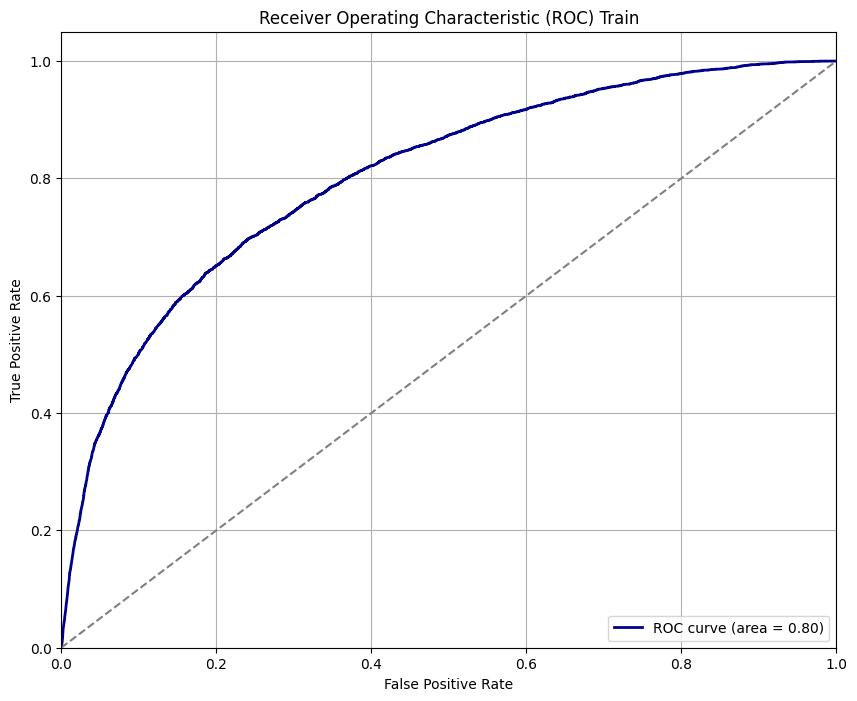

In [38]:
plot_roc_curve(y_true,y_pred_prob,"train")

Evaluation Metrics on Test Dataset

In [39]:
y_pred = xgb_model.predict(X_test_pc.select_dtypes(include='number'))
y_pred_prob = xgb_model.predict_proba(X_test_pc.select_dtypes(include='number'))[:, 1]  # Probabilities for the positive class
y_true = y_test.values.ravel()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.32      0.48      4673
           1       0.28      0.94      0.43      1327

    accuracy                           0.46      6000
   macro avg       0.62      0.63      0.46      6000
weighted avg       0.80      0.46      0.47      6000



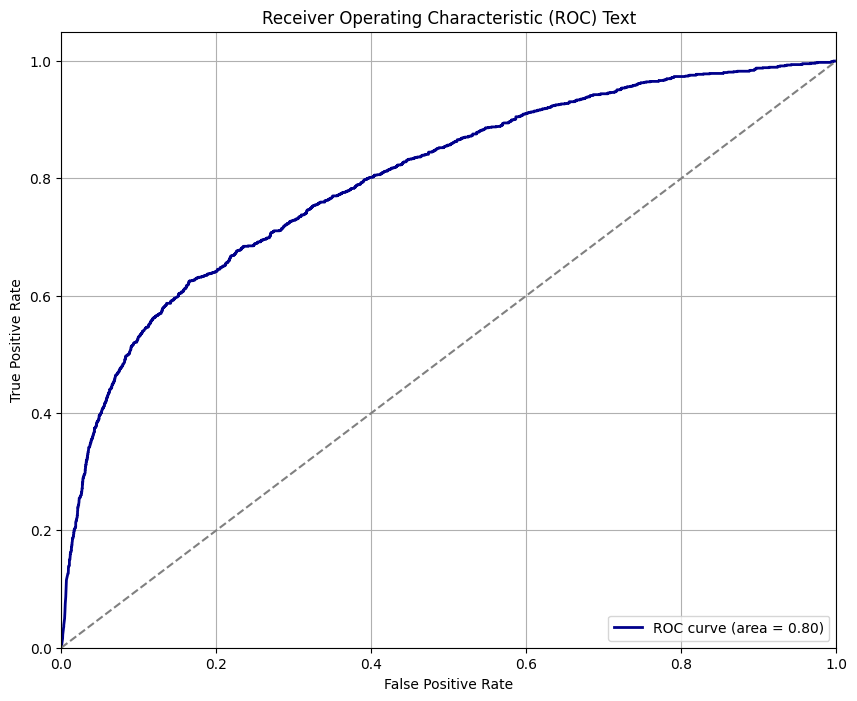

In [40]:
plot_roc_curve(y_true,y_pred_prob,"test")

The base model does not appear to be overfitting, as the performance metrics are similar for both the training and test datasets. However, the overall score is relatively low, indicating that the model requires optimization to improve its performance

An XGBoost with better parameters


In [41]:
# !pip3 install scikit-optimize xgboost

In [42]:
# Define the search space
search_space = {
    'n_estimators': Integer(50, 800),
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'max_depth': Integer(2, 4),
    'scale_pos_weight': Integer(0,50),
    'alpha': Real(0.01, 10, prior='log-uniform'),
    'reg_lambda': Real(0.01, 10, prior='log-uniform'),
    'gamma': Real(0.01, 10, prior='log-uniform')
}

# Define the model
xgb_model = xgb.XGBClassifier(
    n_jobs=-1,
    random_state=seed   # Set random state for reproducibility
)

# Perform Bayesian Optimization
opt = BayesSearchCV(
    xgb_model,
    search_space,
    n_iter=5,  # Number of iterations
    scoring='roc_auc',
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,
    verbose=1,
    random_state=seed  # Set random state for BayesSearchCV
)

# Fit the model
opt.fit(X_train_pc, y_train.values.ravel())

# Extract the best estimator from the BayesSearchCV object
best_model = opt.best_estimator_

# Best parameters
print("Best parameters found: ", opt.best_params_)
print("Best ROC AUC score: ", opt.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  OrderedDict({'alpha': 0.10242142005037684, 'gamma': 1.9558222632307192, 'learning_rate': 0.07510100548868204, 'max_depth': 3, 'n_estimators': 558, 'reg_lambda': 4.568103618366588, 'scale_pos_weight': 6})
Best ROC AUC score:  0.7768668292987232


Evaluation Metrics on Train Dataset

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     18691
           1       0.37      0.83      0.51      5309

    accuracy                           0.65     24000
   macro avg       0.65      0.72      0.62     24000
weighted avg       0.80      0.65      0.68     24000

Confusion Matrix:
[[11249  7442]
 [  894  4415]]


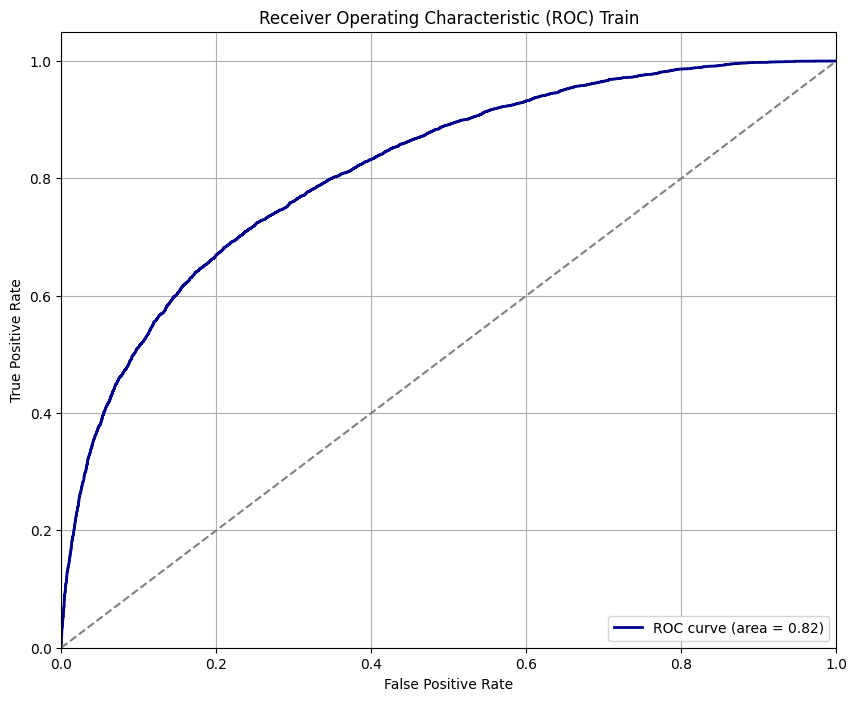

In [47]:
y_pred = best_model.predict(X_train_pc)
y_pred_prob = best_model.predict_proba(X_train_pc)[:, 1]  # Probabilities for the positive class
y_true = y_train.values.ravel()

print(classification_report(y_true, y_pred))

# Compute and print confusion matrix using numpy
conf_matrix = np.zeros((2, 2), dtype=int)  # Initialize 2x2 matrix for binary classification
for true, pred in zip(y_true, y_pred):
    conf_matrix[true, pred] += 1

print("Confusion Matrix:")
print(conf_matrix)

plot_roc_curve(y_true,y_pred_prob,"train" )

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      4673
           1       0.36      0.79      0.50      1327

    accuracy                           0.64      6000
   macro avg       0.64      0.70      0.61      6000
weighted avg       0.79      0.64      0.67      6000

Confusion Matrix:
[[2813 1860]
 [ 275 1052]]


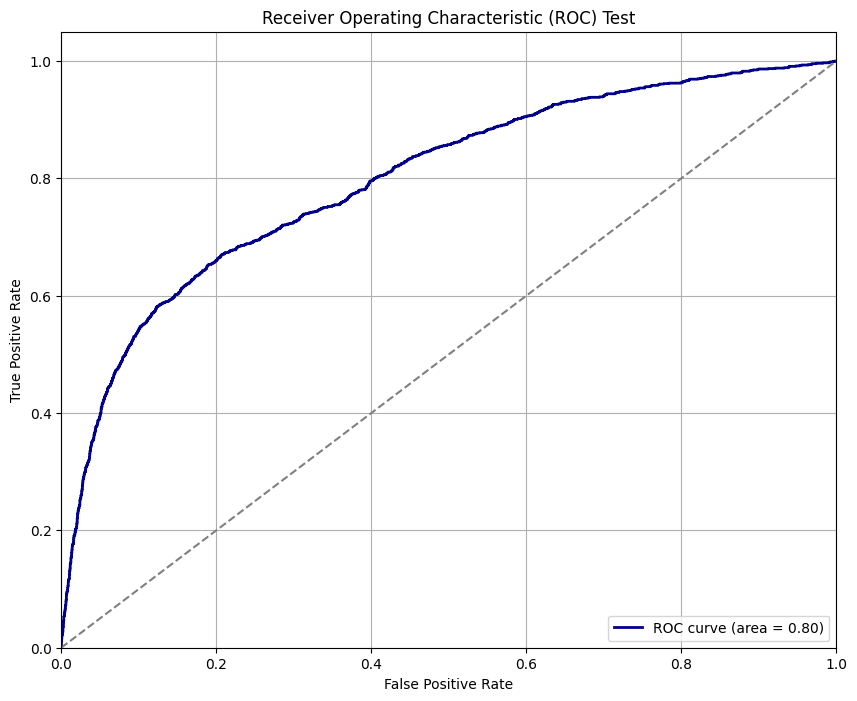

In [52]:
y_pred = best_model.predict(X_test_pc)
y_pred_prob = best_model.predict_proba(X_test_pc)[:, 1]  # Probabilities for the positive class
y_true = y_test.values.ravel()

print(classification_report(y_true, y_pred))

# Compute and print confusion matrix using numpy
evaluation_confusion_matrix = np.zeros((2, 2), dtype=int)  # Initialize 2x2 matrix for binary classification
for true, pred in zip(y_true, y_pred):
    evaluation_confusion_matrix[true, pred] += 1

print("Confusion Matrix:")
print(evaluation_confusion_matrix)

plot_roc_curve(y_true,y_pred_prob,"test" )

The model is not overfitting, and the F1 and AUC scores have improved.

However, it still performs significantly better for class 0 (no default) compared to class 1 (default). This indicates the model is better at predicting no default than identifying defaults.

Before proceeding with further iterations, it is important to consult with business stakeholders to clarify their expectations for model performance and determine acceptable trade-offs between precision and recall for each class. For instance, this model currently exhibits high precision for class 0 (no default), but struggles with accurately identifying defaults (class 1), resulting in very low precision for class 1. This means the model correctly identifies most cases of no default (class 0) but frequently misclassifies defaults (class 1) as no default, which could lead to underestimating the risk of default.








TODO : could we apply SMOTHE to the training data set to balance the classes? 

Business Metrics of the Model over the Evaluation Dataset
